## Analyzing AQI after the Thomas Fire
Annie Adams 

Link to github : https://github.com/annieradams/eds220-hwk4-project-repo/

# About 
**Purpose**: 
The Thomas Fire caused extensive damage in both Ventura and Santa Barbara County in December of 2017. As with all fires, the decrease in air quality index is a a direct effect of wildfires. This project will explore how the air quality index was effected by the Thomas fire. We will look into both numeric AQI data of santa barbara, as well as a collection of bands from the Landsat 8 Satellite. Looking into this different areas will allow us to further investigate how much aqi was affected, and from what bands the effect could be seen. 

**Highlights of analysis**: 
- fetch AQO data, landsat sattelite data, and california fire perimeter shapefile from an online repository
- Clean data with consistent crs' for plotting purposes
- Time series analysis with aqi data
- Visualize landsat raster data with false and true color images
- Compare landsat raster with Thomas fire perimeter 

**Dataset Description** : 

*Landsat data:*

A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. The data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution ([Landsat Collection in MPC](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)).

*CA fire perimeter shapefile:*

A shapefile of fire perimeters in California during 2017. 
The [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about).

*AQI data:*

A daily reporting of AQI by county for 2017 and 2018. Data reports an AQI value, approximately every 3 -7 days, for counties in every state. Also reports the category for AQI, i.e. "good". 
Data reports an AQI value, approximately every 3 -7 days, for 804 counties across every state (as well as Country of Mexico, Puerto Rico, and Virgin Islands). Also reports the category for AQI, i.e. "good", or "hazardous". 

**References to datasets**

Landsat data : https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

Shapefile : https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about

AQI Data : 

https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQIhttps://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI



### Import Packages and the Data

In [ ]:
#import necessary packages

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches # for creating legends
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
from rasterio.features import rasterize #for reasterizing polygons
import matplotlib.lines as mlines

In [ ]:
#read in aqi data for 2017 and 2018
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip') # 2017 data
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip') # 2018 data

# read in shapefile of califronia fire/ perimters
ca_fire = gpd.read_file('data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp') 

#read in landsat data
landsat_fp = os.path.join(os.getcwd(), 'data','landsat8-2018-01-26-sb-simplified.nc') 
landsat = rioxr.open_rasterio(landsat_fp)


## Geographical Context of Data
*Select data pertaining to area of interest (Santa Barbara)*

In [ ]:
 # concatenate 2017 and 2018 data using concat to get one dataframe for all aqi data
aqi = pd.concat([aqi_17, aqi_18])

#only select data in Santa barbara since that is where Thomas fire was 
aqi_sb = aqi[aqi["county Name"] == "Santa Barbara"].drop(columns = ['State Name','county Name','State Code','County Code']) #select Santa barbara and drop unnecessary columns

#only select thomas fire perimeter
thomas_fire = ca_fire[ca_fire.FIRE_NAME == "THOMAS"]



In [ ]:
aqi.head()

In [ ]:
aqi["Category"].unique()

## Data Exploration
Explore information on all three datasets to understand data setup



###### **Aqi dataset**

In [ ]:
print("Number of unique values : \n", aqi_sb.nunique(), "\n") # check number of unique values to get idea on variety of data
print("Column datatypes:\n ", aqi_sb.dtypes, "\n")  # check data types of variables for future reference
print("Shape of data:", aqi_sb.shape) # check shape of data to see how many columns and observations there are

###### **CA fire perimter shapefile**

In [ ]:
print("Column names: \n", ca_fire.columns) # check column names to see what the data contains
print("Shape of data:", ca_fire.shape,"\n") # check shape of data to see how many columns and observations there are
print("Column datatypes:\n ", ca_fire.dtypes, "\n")  # check data types of variables for future reference

###### **Landsat data**

In [ ]:
print("The dimmensions of the landsat data are:\n", landsat.dims,"\n") # check file dimmensions
print("The coordinates of the landsat data are:\n", landsat.coords,"\n") # check coordinates of shapefile
print("The values of the landsat data are:\n",  landsat.values, "\n") # values of xarray
print("The crs of the landsat data is:", landsat.rio.crs) # check crs

## Data Cleaning

###### **Aqi dataset**

In [ ]:
aqi_sb.columns = aqi_sb.columns.str.lower() #make column names lower case
aqi_sb.columns = aqi_sb.columns.str.replace(' ','_') # reassign column names by substituting an underscore for a space
aqi_sb.date = pd.to_datetime(aqi_sb.date) # update data column to datetime
aqi_sb = aqi_sb.set_index('date') # change index to be date

###### **Landsat data**

In [ ]:
# drop band dimension to make data 2D
landsat_2d = landsat.squeeze().drop('band')
landsat_2d # check to make sure band is no longer included

###### **CA fire perimter shapefile**

In [ ]:
thomas_fire= thomas_fire.to_crs(landsat_2d.rio.crs) # change crs of thomas fire to match landsat crs

In [ ]:
#check to make sure crs' match/
thomas_fire.crs == landsat.rio.crs

## Data Analysis

##### Analyze AQI Values in data to see if AQI spikes are present during Thomas Fire
Plot five day average of aqi and daily aqi 

<AxesSubplot:title={'center':'AQI and Five day AQI Average in Santa Barbara County from Jan 2017 to December 2018'}, xlabel='date'>

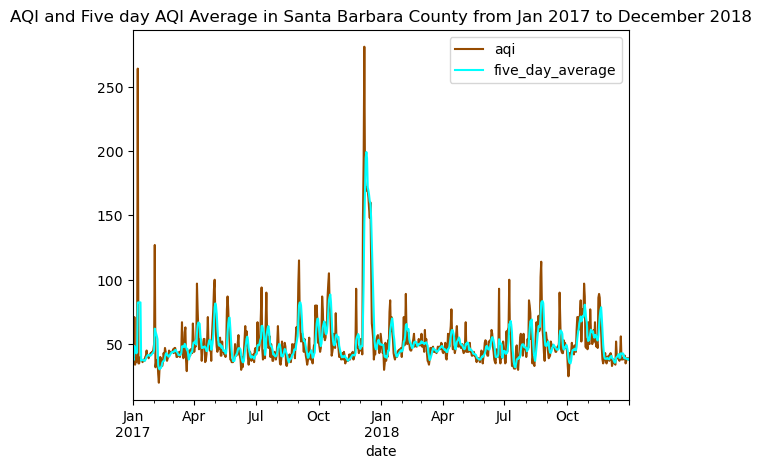

In [33]:
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean() # create new column called 'five_day_average' in aqi_sb data frame that contains a 5 day rolling window
colors = {'aqi': '#964B00', # pick dark brown for aqi
         'five_day_average': 'cyan'}  # pick cyan for five day average
aqi_sb.plot(use_index = True, # include index as x axis
       y = ['aqi','five_day_average'], # plot aqi and five_day_average
       color = colors,
           title = 'AQI and Five day AQI Average in Santa Barbara County from Jan 2017 to December 2018') # have colors be pre defined colors dictionary, add title


##### Can also use Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data to analyze aqi

Create a true color image by plotting the red, green, and blue variables.


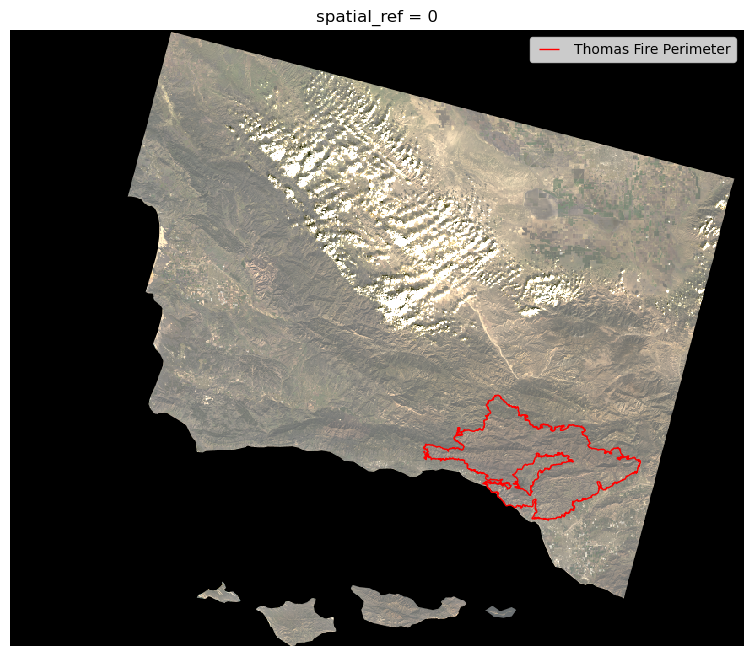

In [30]:
fig, ax = plt.subplots(figsize = (12,8)) # set figure size and axis
ax.axis('off') # turn x and y axis off

# -------------------------
landsat_2d[['red', 'green', 'blue']].to_array().plot.imshow(ax = ax,robust = True)
thomas_fire.plot(ax = ax,color = 'None', edgecolor = 'red') # plot california map with black outline 
thomas_line = mlines.Line2D([], [], color='red', marker='_', # make legend have triangle #update legend name and marker
                          markersize=15, label='Thomas Fire Perimeter', linestyle = 'None')

#---------------------------

# create legend
ax.legend(handles = [thomas_line], frameon = True, loc = 'upper right') # add legend in upper right corner

#---------------------------

plt.show()  # show plot

Create a false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables.


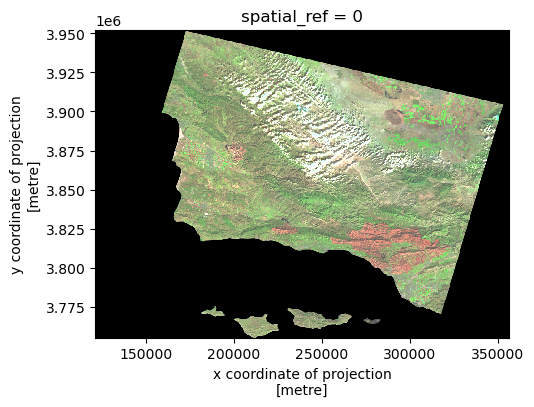

In [32]:
#select short wave, near infrared, and red variables, make an array and plot with robust = True
landsat_2d[[ 'swir22','nir08', 'red']].to_array().plot.imshow(size = 4, robust = True)

This image looks good, but we want to look closer at the Thomas fire region. We can zoom in on the Thomas fire region to see that the landsat imaage picked up for the region. 

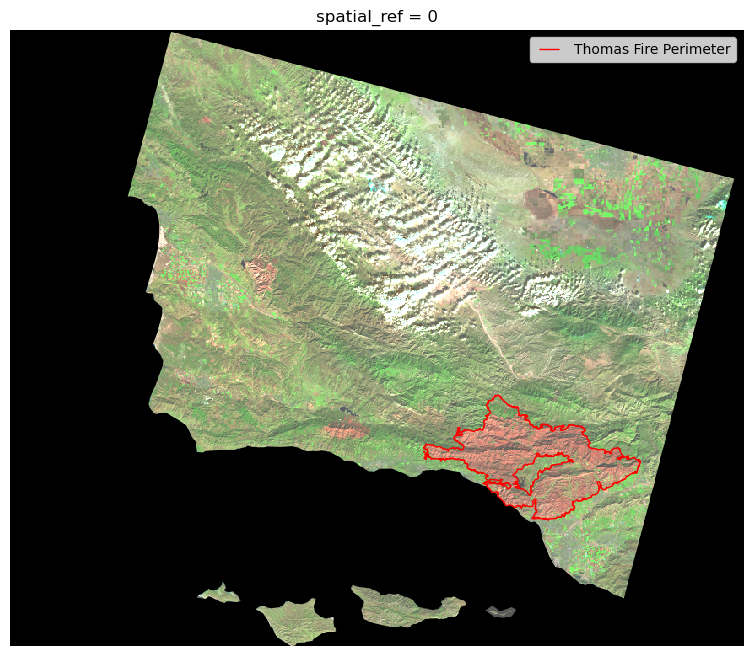

In [31]:
fig, ax = plt.subplots(figsize = (12,8)) # set figure size and axis
ax.axis('off') # turn x and y axis off

# -------------------------
landsat_2d[['swir22','nir08', 'red']].to_array().plot.imshow(ax = ax,robust = True)
thomas_fire.plot(ax = ax,color = 'None', edgecolor = 'red') # plot california map with red outline 
thomas_line = mlines.Line2D([], [], color='red', marker='_', #make legend symbol be a line and change color to red, add label
                          markersize=15, label='Thomas Fire Perimeter', linestyle = 'None')

#---------------------------

# create legend
ax.legend(handles = [thomas_line], frameon = True, loc = 'upper right') # add legend in upper right corner
#---------------------------

plt.show()  # show plot


## Final Results

The AQI time series graph and landsat image above both display increased AQI levels during the Thomas fire. The time series graph has a spike in AQI during December of 2017/ January 2018. This corresponds to the time of the Thomas Fire, when we would expect AQI to increase. The false color image above also shows a decrease in air quality in the band that matches the coordinates of the Thomas fire. From both these plots, we can see that the air quality was significantly effected by the Thomas Fire. This change is evident in both numeric data reporting AQI levels, as well as satellite data. 